# Hash checking effectiveness analysis

In this script we will show an example of using the VyPR Analysis Library to visualise the effectiveness of hash checking in optimising Conditions upload process. The service is checked for the requirement that the number of hashes not found should exceed 70% of the original list of hashes. The intuition here is that the optimisation should have a sufficient effect on the upload process that its removal would cause significantly different behaviour.

Begin with importing the necessary modules and setting up the verdict server.

In [1]:
import sys
sys.path.append("..")
import ast
import pprint
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cbook as cbook
from dateutil.parser import isoparse
import traceback
import json
import argparse

import VyPRAnalysis as va
va.prepare("verdicts_4000_hash_check_effectiveness.db")
va.set_monitored_service_path("uploader-experiments/uploader/")

Failed to connect to server.
Connected to server


'uploader-experiments/uploader/'

Iterate through the calls of the hash checking function to gather the observed number of the checked hashes during each call, as well as the number of those that were not found. 

In [2]:
hash_checking_function = va.list_functions()[0]
all_calls = hash_checking_function.get_calls()
n_of_calls = len(all_calls)

hashes_length_to_not_found_list = {}

hash_lengths = []

for (n, call) in enumerate(all_calls):
  if n % 100 == 0:
    print("Processed %i/%i calls." % (n, n_of_calls))
  # there will be a single verdict
  verdict = call.get_verdicts()[0]
  # in case we only care about failing verdicts replace the conditional with:
  #if verdict.verdict == 0:
  if True:
    observations = verdict.get_observations()
    lhs_obs = filter(lambda obs : obs.sub_index == 0, observations)[0]
    rhs_obs = filter(lambda obs : obs.sub_index == 1, observations)[0]
    total_hashes = ast.literal_eval(lhs_obs.observed_value)["hashes"]

    if total_hashes in hash_lengths:
      length_index = hash_lengths.index(total_hashes)
    else:
      hash_lengths.append(total_hashes)
      length_index = len(hash_lengths)-1

    not_found = ast.literal_eval(rhs_obs.observed_value)["not_found"]
    if length_index not in hashes_length_to_not_found_list:
      hashes_length_to_not_found_list[length_index] = [not_found]
    else:
      hashes_length_to_not_found_list[length_index].append(not_found)

Processed 0/4000 calls.
Processed 100/4000 calls.
Processed 200/4000 calls.
Processed 300/4000 calls.
Processed 400/4000 calls.
Processed 500/4000 calls.
Processed 600/4000 calls.
Processed 700/4000 calls.
Processed 800/4000 calls.
Processed 900/4000 calls.
Processed 1000/4000 calls.
Processed 1100/4000 calls.
Processed 1200/4000 calls.
Processed 1300/4000 calls.
Processed 1400/4000 calls.
Processed 1500/4000 calls.
Processed 1600/4000 calls.
Processed 1700/4000 calls.
Processed 1800/4000 calls.
Processed 1900/4000 calls.
Processed 2000/4000 calls.
Processed 2100/4000 calls.
Processed 2200/4000 calls.
Processed 2300/4000 calls.
Processed 2400/4000 calls.
Processed 2500/4000 calls.
Processed 2600/4000 calls.
Processed 2700/4000 calls.
Processed 2800/4000 calls.
Processed 2900/4000 calls.
Processed 3000/4000 calls.
Processed 3100/4000 calls.
Processed 3200/4000 calls.
Processed 3300/4000 calls.
Processed 3400/4000 calls.
Processed 3500/4000 calls.
Processed 3600/4000 calls.
Processed 370

Convert the gathered lengths of the not found and all checked hashes into percentage values.

In [3]:
hashes_length_to_percentages = {}
for hash_length_index in hashes_length_to_not_found_list:
  n_of_hashes_given = hash_lengths[hash_length_index]
  percentages = []

  for not_found in hashes_length_to_not_found_list[hash_length_index]:
    percentages.append(100*(float(not_found)/float(n_of_hashes_given)))

  hashes_length_to_percentages[hash_length_index] = percentages

Manually construct the bins for hash lengths and group the percentages into corresponding bins.

In [4]:
bins = [[0, 10], [10, 20], [20, 30], [30, 40], [40, 50], [50, 60], [60, 80], [80, 100], [100, 200], [200, 300], [300, 2000]]
groups = [[] for bin in bins]

bin_as_label = lambda bin : "[%i, %i)" % tuple(bin)
bin_strings = map(bin_as_label, bins)

# put hash lengths into bins
for (length_index, hash_length) in enumerate(hash_lengths):
  for (n, bin) in enumerate(bins):
    if bin[0] <= hash_length < bin[1]:
      groups[n] += hashes_length_to_percentages[length_index]

Finally, create the plot showing the boxplots showing the distribution of the percentage of the hashes not found, grouped by the total number of hashes checked. We see that Conditions uploads which propose a high number of Payloads often upload Conditions that do not already exist. From this we take two key results: 

- We must consider making hash checking an optional part of the Conditions upload process if it takes a long time in cases where it has little benefit 
    
- Instances where hash checking takes a long time are often those where the Payloads do not exist, so the problem in these instances cannot be that the checking query is fetching too much data.

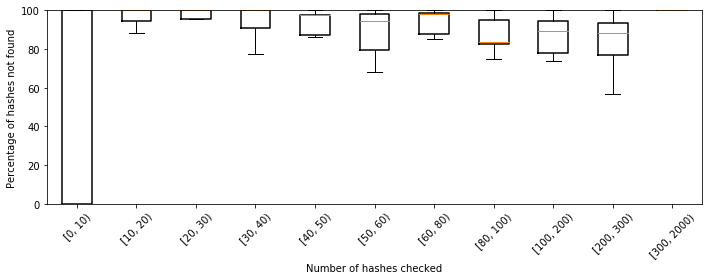

In [8]:
# derive boxplot statistics
stats = cbook.boxplot_stats(groups, labels=bin_strings)

# draw plot
fig, ax = plt.subplots()

fig.set_figheight(4)
fig.set_figwidth(10)

plt.xticks(rotation=45)

plt.ylim([0, 100])

plt.xlabel("Number of hashes checked")
plt.ylabel("Percentage of hashes not found")

ax.bxp(stats, showfliers=False)

plt.tight_layout()
plt.show()

In [6]:
va.teardown()